# LAB 3-1

In [16]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from random import shuffle

In [17]:
df = pd.read_csv('netflix-rotten-tomatoes-metacritic-imdb.csv')
df.drop(columns=["Title","Series or Movie"], axis=1)
df = df.replace('?', np.NaN)
df = df.dropna()
df['Genre'] = pd.Categorical(df['Genre'])

In [18]:
num_df = df.select_dtypes(include='int64').copy()
num_df['y'] = df['Genre'].cat.codes
for column in num_df.columns:
    scale = StandardScaler().fit(num_df[[column]])
    num_df[[column]] = scale.transform(num_df[[column]])

PCA

In [28]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(num_df.values)
num_df['pca1'] = pca_result[:,0]
num_df['pca2'] = pca_result[:,1] 
num_df['pca3'] = pca_result[:,2]

<AxesSubplot:xlabel='pca1', ylabel='pca2'>

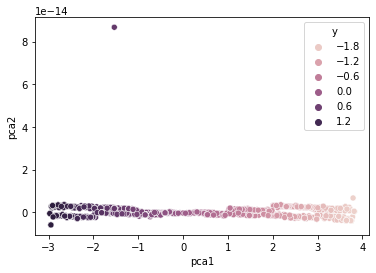

In [29]:
plt.figure()
sns.scatterplot(
    x="pca1", y="pca2",
    hue="y",
    data=num_df)

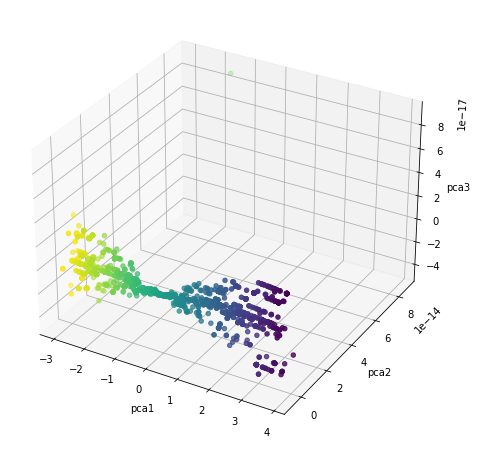

In [30]:
ax = plt.figure(figsize=(14,8)).gca(projection='3d')
ax.scatter(
    xs=num_df["pca1"], 
    ys=num_df["pca2"], 
    zs=num_df["pca3"], 
    c=num_df["y"]
)
ax.set_xlabel('pca1')
ax.set_ylabel('pca2')
ax.set_zlabel('pca3')
plt.show()

TSNE

<AxesSubplot:xlabel='tsne1', ylabel='tsne2'>

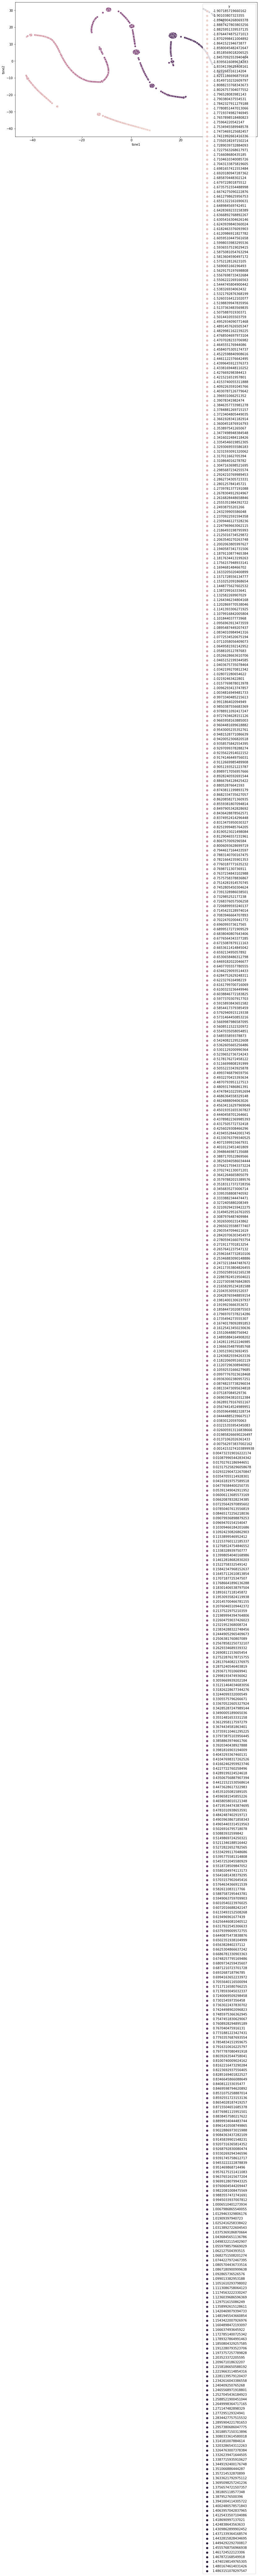

In [31]:
tsne = TSNE(n_components=2, perplexity=40, n_iter=500)
tsne_results = tsne.fit_transform(num_df)
num_df['tsne1'] = tsne_results[:,0]
num_df['tsne2'] = tsne_results[:,1]
plt.figure(figsize=(14,8))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="y",
    data=num_df,
    legend="full",
)

# LAB 3-2

In [1]:
import numpy as np


import requests
import io
from PIL import Image

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.utils import shuffle

In [2]:
img_link = 'https://static01.nyt.com/images/2021/09/14/science/07CAT-STRIPES/07CAT-STRIPES-superJumbo.jpg?quality=75&auto=webp'

In [3]:
resp = requests.get(img_link)
img: Image.Image = Image.open(io.BytesIO(resp.content))
resized_img = img.resize((int(img.width / 4), int(img.height / 4)), Image.ANTIALIAS)

img_array = np.array(np.asarray(resized_img), dtype=np.float64) / 255

w, h, d = original_shape = tuple(img_array.shape)
image_array = np.reshape(img_array, (w * h, d))
image_array_sample = shuffle(image_array, random_state=0, n_samples=1_000)

kmeans_map = [(n_cluster, KMeans(n_clusters=n_cluster, random_state=0).fit(image_array_sample)) for n_cluster in (8, 16, 32, 64)]
kmeans_with_labels = [(n_cluster, mean_obj, mean_obj.predict(image_array)) for n_cluster, mean_obj in kmeans_map]

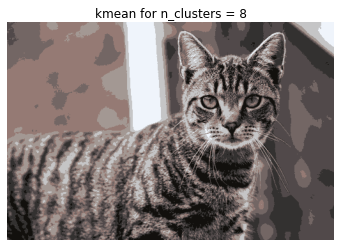

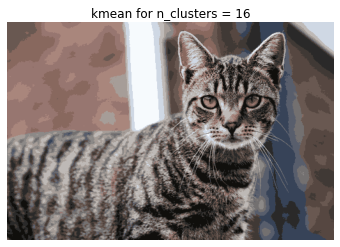

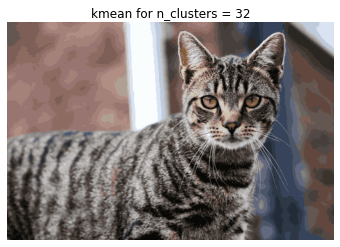

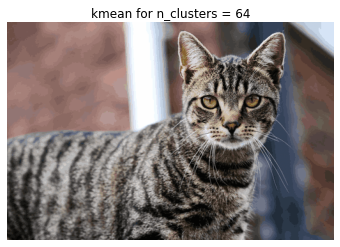

In [4]:
def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    return codebook[labels].reshape(w, h, -1)


for figure_pos, packed_kmeans in enumerate(kmeans_with_labels):
    n_cluster, mean_obj, labels = packed_kmeans
    plt.figure(figure_pos)
    plt.clf()
    plt.axis('off')
    plt.title(f'kmean for n_clusters = {n_cluster}')
    plt.imshow(recreate_image(mean_obj.cluster_centers_, labels, w, h))

plt.show()

# LAB 3-3

In [5]:
import numpy as np
from sklearn.mixture import GaussianMixture

In [6]:
synt1 = np.random.multivariate_normal(
    mean=[0, 1],
    cov=[[1, 0], [0, 100]],
    size=10
)

synt2 = np.random.multivariate_normal(
    mean=[0, 1],
    cov=[[1, 10], [10, 100]],
    size=10
)

synt_big = (synt1 + synt2)


gm = GaussianMixture(n_components=2, random_state=0, covariance_type='tied').fit(X=synt_big)

print(gm.means_)
print(gm.weights_)
print(gm.covariances_)

[[ -0.5803057  -11.30039413]
 [  1.12043887  19.58932577]]
[0.53185978 0.46814022]
[[ 1.95511192  6.10241886]
 [ 6.10241886 86.14302191]]


# LAB 3-4

In [1]:
import string
import pickle
import os
import wordcloud
import nltk
from time import time
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gress\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# nltk.download()

In [3]:
def _load_data(file='parsed.txt'):
    _t = time()
    data = pickle.loads(open('parsed.txt', 'rb').read())
    print(f'loaded {file} in {time() - _t} seconds')
    return data

In [4]:
def part1():
    """
    open file with raw data, parse it,
     remove punctuation, and save in `parsed.txt` file
    """
    if os.path.isfile('./parsed.txt'):
        print('file exists skipping')
        return

    dataset_raw = open('test.ft.txt', encoding="utf8").read()

    dataset_lines_raw = dataset_raw.split('\n')

    class_map = {'__label__1 ': 'bad', '__label__2 ': 'good'}
    dataset_classes_parsed = []
    for raw_line in dataset_lines_raw:
        try:
            clazz = class_map[raw_line[:11]]
        except KeyError:
            print(f'key error: {raw_line[:11]}')
            continue
        text = raw_line[11:].translate(str.maketrans('', '', string.punctuation))
        dataset_classes_parsed.append(
            (clazz, ' '.join([word.upper() for word in text.split(' ')]))
        )

    print(dataset_classes_parsed)

    open('parsed.txt', 'wb').write(pickle.dumps(dataset_classes_parsed))

In [5]:
def part2():
    """
    open parsed file, get all msgs, concat them, and
    generate a wordcloud from them and save it to `img.png`
    """

    if os.path.isfile('./img.png'):
        print('image exists, skipping')
        return

    data = _load_data()
    text = ' '.join([text for _, text in data])
    wc = wordcloud.WordCloud()
    wc.generate(text)
    wc.to_image().save('img.png', format='png')

In [6]:
def part3():
    """
    vectorize messages and classify and generate metrics
    """
    from nltk.corpus import stopwords
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

    data = _load_data()
    msgs = [msg for _, msg in data]
    classes = [clazz for clazz, _ in data]

    tfidconverter = TfidfVectorizer(max_features=250, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
    X = tfidconverter.fit_transform(msgs).toarray()
    X_train, X_test, y_train, y_test = train_test_split(X, classes, test_size=0.2, random_state=0)

    classifier = RandomForestClassifier(n_estimators=1000, random_state=0)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)


    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print(accuracy_score(y_test, y_pred))

In [7]:
part1()
part2()
part3()

file exists skipping
image exists, skipping
loaded parsed.txt in 0.40516066551208496 seconds
[[32023  8056]
 [ 7795 32126]]
              precision    recall  f1-score   support

         bad       0.80      0.80      0.80     40079
        good       0.80      0.80      0.80     39921

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000

0.8018625
